In [63]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
# from topoPy import *

In [118]:
def readnc(datfile,var):
    #---- topography data file
    df = nc.Dataset(datfile)
    # print(df.variables)
    
    #---- variable and coordinates
    lon, lat = df.variables['lon'][:], df.variables['lat'][:]
    z = df.variables[var['name']][:]
    df.close()
    
    return lon, lat, z

def fetch_vwdata_by_idx(datfile,var,lon_centre,lat_centre,lon_vert,lat_vert,links):
    
    #---- variable and the coordinates
    lon, lat, z = readnc(datfile, var)
    
    #---- get number of records,nlat,nlon
    nrecords = np.shape(z)[0]; nlon = np.shape(lon)[1]; nlat = np.shape(lat)[1]
    
    #---- process each record to get the (lon,lat) for each topographic observation in 1D
    lon_res=[]; lat_res=[]; z_res=[]   # resulting lon,lat,z  
    
    for n in links:
        # print('n = ',n)
        lon_,lat_ = np.meshgrid(lon[n][:],lat[n][:])
#         print(lon_, lat_)
        lon_= lon_.ravel() 
        lat_ = lat_.ravel() 
        z_ = np.flipud(z[n][:]).ravel() 
#         print(lon_.shape, lat_.shape, z_.shape)
        cond_lat = ( lat_vert.min() <= lat_ ) & ( lat_ <= lat_vert.max() )
        cond_lon = ( lon_vert.min() <= lon_ ) & ( lon_ <= lon_vert.max() )
        idx = np.nonzero((cond_lat & cond_lon))[0]

        # idx = np.nonzero((np.abs(lon_ - lon_centre)<= lon_width/2) & 
                         # (np.abs(lat_ - lat_centre)<= lat_width/2))[0]
        # print(idx)
        if len(idx)!=0:
            lon_dummy,lat_dummy,z_dummy = lon_[idx],lat_[idx],z_[idx]
            lon_res.extend(lon_dummy.tolist())
            lat_res.extend(lat_dummy.tolist())
            z_res.extend(z_dummy.tolist())
    
    lon_res = np.array(lon_res)
    lat_res = np.array(lat_res)
    z_res = np.array(z_res)
        
    del lat, lon, z
        
    #---- processing of the lat,lon,topo to get the regular 2D grid for topography
    lon_uniq, lat_uniq = np.unique(lon_res), np.unique(lat_res) # get unique values of lon,lat
    nla = len(lat_uniq); nlo = len(lon_uniq)
    
#     print("lat_res shape = ", lat_res.shape)
#     print("lon_res shape = ", lon_res.shape)
#     print("z_res shape = ", z_res.shape)
#     print("nla = ", nla)
#     print("nlo = ", nlo)

    #---- building 2D topography field
    lat_lon_topo = np.vstack((lat_res,lon_res,z_res)).T
    lat_lon_topo = lat_lon_topo[lat_lon_topo[:,0].argsort()]  # sorted according to latitude
    lon_sort_id = [lat_lon_topo[n*nlo:(n+1)*nlo,1].argsort()+nlo*n for n in range(nla)] 
    lon_sort_id = np.array(lon_sort_id).reshape(-1)
    lat_lon_topo = lat_lon_topo[lon_sort_id]  # sorted according to longitude for each len(lon_u)
    topo_2D = np.reshape(lat_lon_topo[:,2],(nla,nlo))
    del lat_lon_topo, lon_sort_id
        
    # print('Data fetched...')
    return lon_uniq, lat_uniq, topo_2D

[[3 0 0 0 0 0]
 [2 0 0 0 0 0]
 [2 5 0 0 0 0]
 [2 0 0 0 0 0]
 [1 0 0 0 0 0]
 [4 6 0 0 0 0]]
CPU times: user 132 ms, sys: 190 ms, total: 321 ms
Wall time: 323 ms


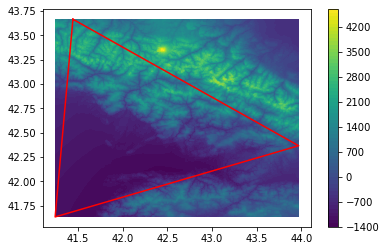

CPU times: user 134 ms, sys: 59.7 ms, total: 194 ms
Wall time: 194 ms


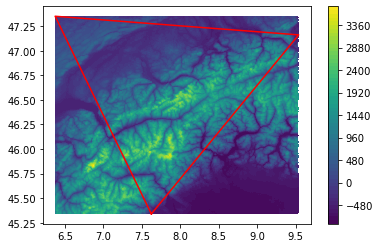

CPU times: user 244 ms, sys: 86.4 ms, total: 330 ms
Wall time: 339 ms


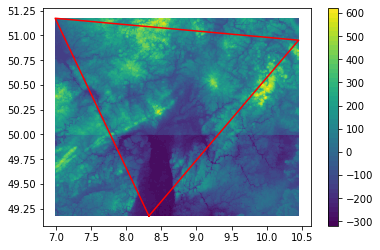

CPU times: user 132 ms, sys: 60 ms, total: 192 ms
Wall time: 192 ms


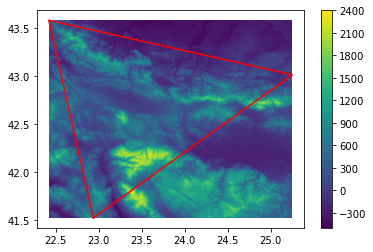

CPU times: user 140 ms, sys: 69.5 ms, total: 210 ms
Wall time: 211 ms


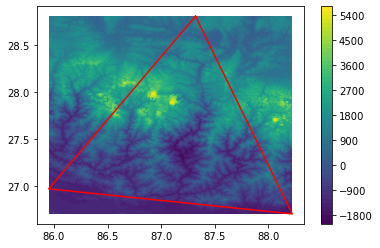

CPU times: user 192 ms, sys: 73.1 ms, total: 265 ms
Wall time: 266 ms


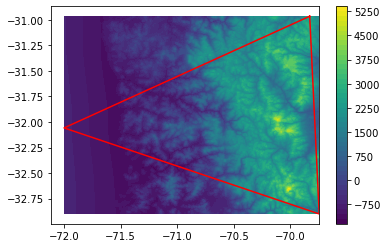

In [190]:
df = nc.Dataset('../data/icon_compact_linked_6.nc')

clat = df.variables['clat'][:]
clon = df.variables['clon'][:]
clat_vertices = df.variables['clat_vertices'][:]
clon_vertices = df.variables['clon_vertices'][:]
links = df.variables['links'][:]

df.close()

print(links)

clat = clat*(180/np.pi)
clon = clon*(180/np.pi)

clat_vertices = clat_vertices*(180/np.pi)
clon_vertices = clon_vertices*(180/np.pi)

datfile = '../data/topo_compact_6.nc'
var = {'name':'topo','units':'m'}

# lon, lat, z = readnc(datfile, var)
# nrecords = np.shape(z)[0]; nlon = np.shape(lon)[1]; nlat = np.shape(lat)[1]

for vid in range(0,6):
    lat_centre = clat[vid]
    lon_centre = clon[vid]
    lat_vert = clat_vertices[vid,:]
    lon_vert = clon_vertices[vid,:]
    
    nonzero_links = links[vid,:]
    nonzero_links = nonzero_links[nonzero_links > 0]

#     # ---- get the topography around the cell picked

    %time lon,lat,z = fetch_vwdata_by_idx(datfile,var,lon_centre,lat_centre,lon_vert,lat_vert,nonzero_links-1)
    
    plt.contourf(lon,lat,z,60)
    x = np.append(clon_vertices[vid,:],clon_vertices[vid,0])
    y = np.append(clat_vertices[vid,:],clat_vertices[vid,0])
    plt.plot(x,y,'-r')
    plt.colorbar()
    plt.show()

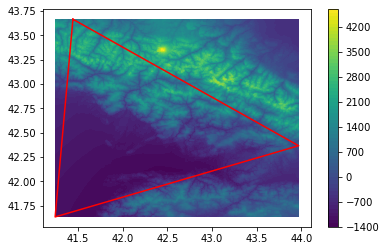

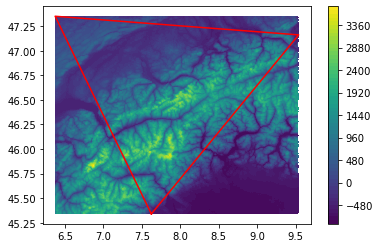

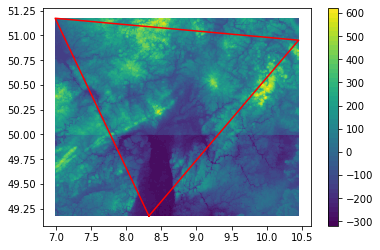

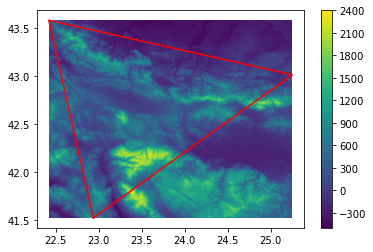

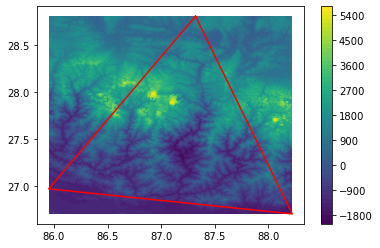

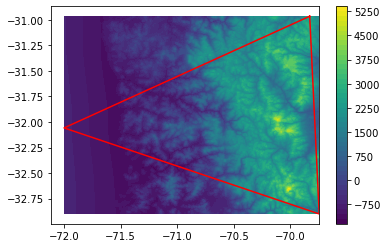

In [191]:
df = nc.Dataset('../data/output_6.nc')

for i in range(1,7):
    name = "topo_%i" %i
    lat_name = "lat_grid_%i" %i
    lon_name = "lon_grid_%i" %i
    
    data = df.variables[name][:]
    lat_grid = df.variables[lat_name][:]
    lon_grid = df.variables[lon_name][:]

    plt.contourf(lon_grid, lat_grid, data, 60)
    
    vid = i-1
    x = np.append(clon_vertices[vid,:],clon_vertices[vid,0])
    y = np.append(clat_vertices[vid,:],clat_vertices[vid,0])
    plt.plot(x,y,'-r')
    plt.colorbar()
    plt.show()

df.close()

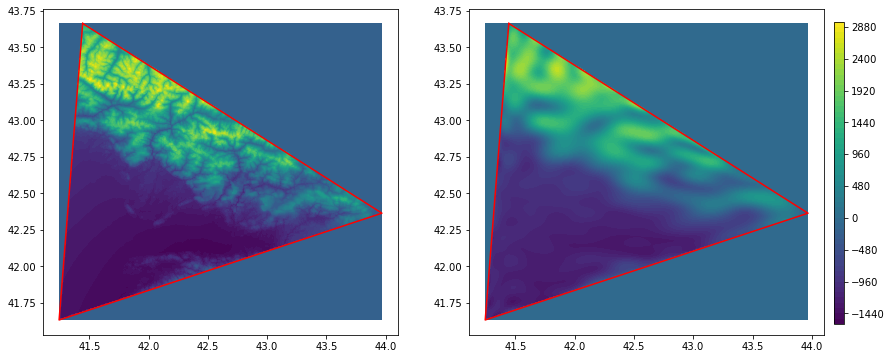

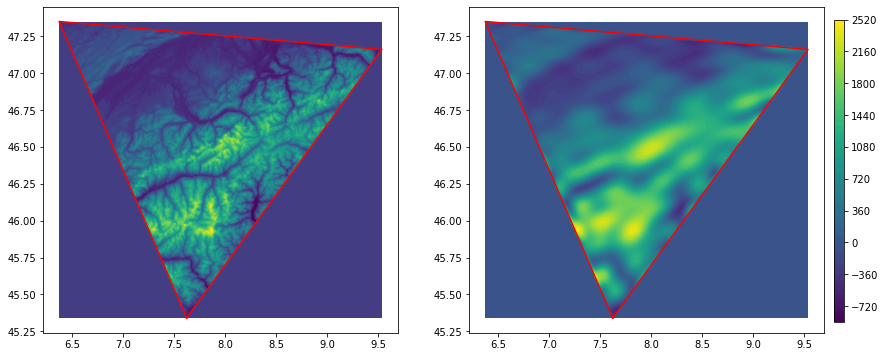

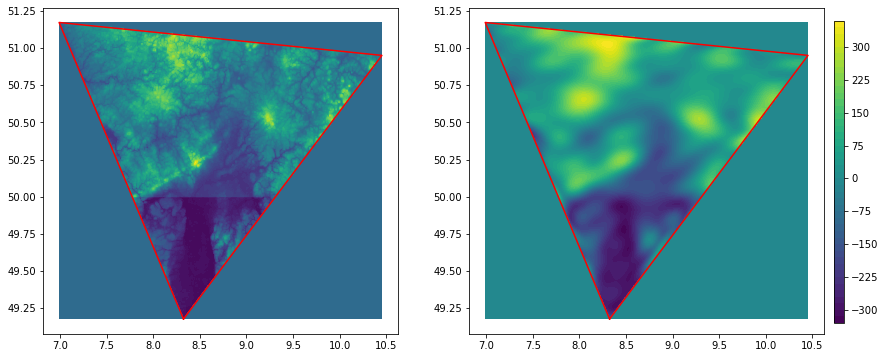

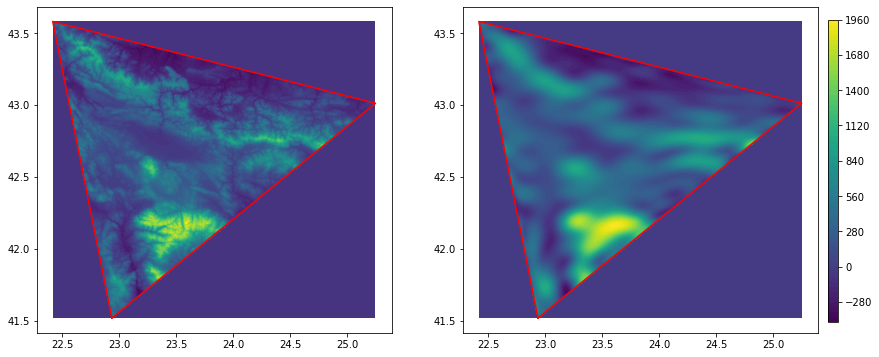

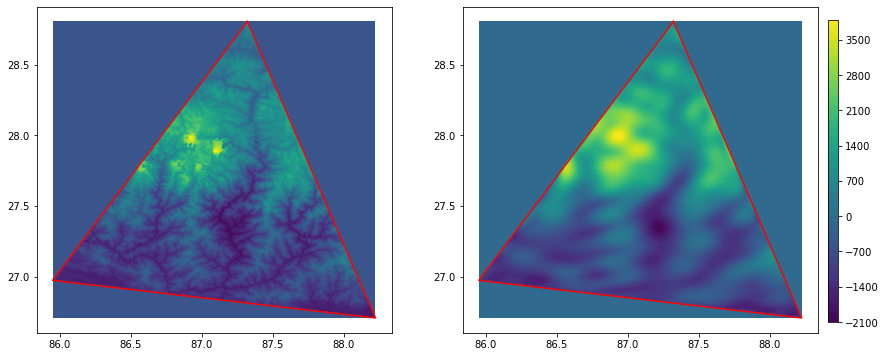

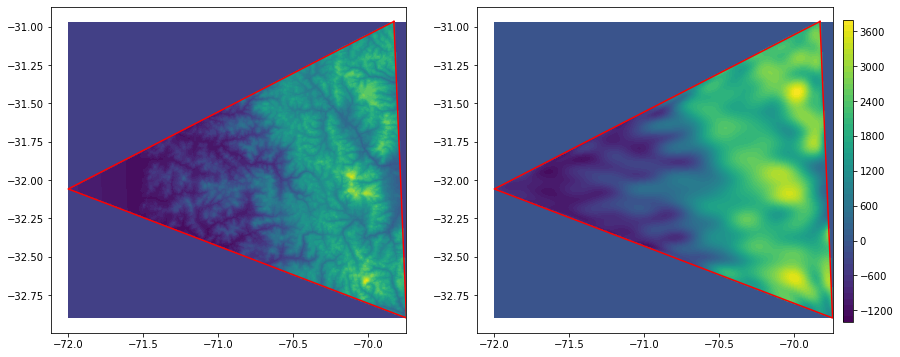

In [192]:
df = nc.Dataset('../data/output_6.nc')

for i in range(1,7):
    name = "topo_%i" %i
    lat_name = "lat_grid_%i" %i
    lon_name = "lon_grid_%i" %i
    recon_name = "topo_recon_%i" %i
    mask_name = "mask_%i" %i
    
    data = df.variables[name][:]
    lat_grid = df.variables[lat_name][:]
    lon_grid = df.variables[lon_name][:]
    topo_grid = df.variables[recon_name][:]
    mask = df.variables[mask_name][:]
    
    data_masked = data*mask
    # fig = plt.figure()
    # gs = fig.add_gridspec(1, 2, hspace=0, wspace=0.1)
    # (ax1, ax2) = gs.subplots()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    im1 = ax1.contourf(lon_grid, lat_grid, data_masked, 60)
    
    vid = i-1
    x = np.append(clon_vertices[vid,:],clon_vertices[vid,0])
    y = np.append(clat_vertices[vid,:],clat_vertices[vid,0])
    ax1.plot(x,y,'-r')
    
    im2 = ax2.contourf(lon_grid, lat_grid, topo_grid, 60)
    ax2.plot(x,y,'-r')
    cbar_ax = fig.add_axes([0.91, 0.15, 0.01, 0.7])
    fig.colorbar(im2, cax=cbar_ax)
    plt.show()

df.close()